In [59]:
# Importations
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

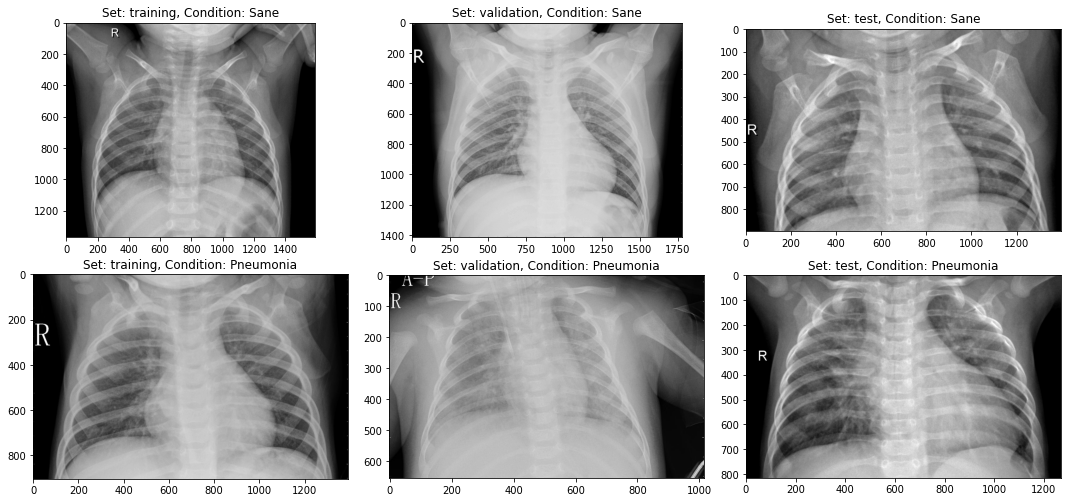

In [83]:
# Data preview
input_path = './dataset/'
dataset_enum = enumerate(['training', 'validation', 'test'])

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in dataset_enum:
    set_path = input_path + _set
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Sane'.format(_set))
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [84]:
# Data distribution
for _set in ['training', 'validation', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('{} set: normal images = {} | pneumonia images = {}'.format(_set, n_normal, n_infect))

training set: normal images = 199 | pneumonia images = 199
validation set: normal images = 8 | pneumonia images = 8
test set: normal images = 200 | pneumonia images = 200


In [62]:
input_path = './dataset/'

def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(
    directory=input_path + 'training', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path + 'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    test_data = []
    test_labels = []
    for status in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + status)):
            img = plt.imread(input_path + 'test' + status + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if status == '/NORMAL/':
                label = 0
            elif status == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [78]:
# Setting hyperparameters
img_dims = 150
epochs = 30
batch_size = 64

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 398 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [79]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# Convulotion 1
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 2
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 3
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 4
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# 5
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [80]:
# Fit model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/30
6/6 [==============================] - 23s 4s/step - loss: 0.6933 - accuracy: 0.4880 - val_loss: 0.6934 - val_accuracy: 0.4922
Epoch 2/30
6/6 [==============================] - 23s 4s/step - loss: 0.6943 - accuracy: 0.4948 - val_loss: 0.6972 - val_accuracy: 0.5030
Epoch 3/30
6/6 [==============================] - 20s 3s/step - loss: 0.6797 - accuracy: 0.5634 - val_loss: 0.6934 - val_accuracy: 0.4851
Epoch 4/30
6/6 [==============================] - 22s 4s/step - loss: 0.5711 - accuracy: 0.7605 - val_loss: 0.6931 - val_accuracy: 0.4762

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/30
6/6 [==============================] - 24s 4s/step - loss: 0.2871 - accuracy: 0.8958 - val_loss: 0.6910 - val_accuracy: 0.4911
Epoch 6/30
6/6 [==============================] - 21s 4s/step - loss: 0.2763 - accuracy: 0.9102 - val_loss: 0.6734 - val_accuracy: 0.5089

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 7/30

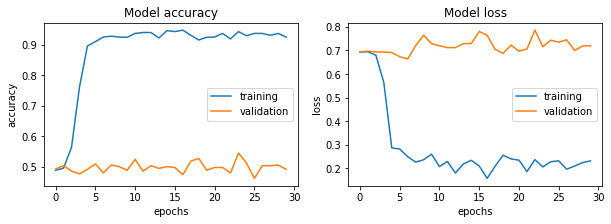

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[metric])
    ax[i].plot(hist.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['training', 'validation'])

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds)) * 100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX
print(cm)

print('\nTEST METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2 * precision * recall / (precision + recall)))

print('\nTRAIN METRIC')
print('Training accuracy: {}%'.format(np.round((hist.history['accuracy'][-1]) * 100, 2)))

CONFUSION MATRIX ------------------
[[  0 200]
 [  0 200]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: 50.0%
Recall: 100.0%
F1-score: 66.66666666666667

TRAIN METRIC ----------------------
Training accuracy: 92.51%
